# Notebook 04: Loss Given Default (LGD) and Exposure at Default (EAD) Estimation

## CECL Credit Risk Modeling for Agricultural Loan Portfolio

---

**Author:** Prabhu  

---

### Objective

This notebook estimates Loss Given Default (LGD) and Exposure at Default (EAD) components for our ECL calculation:

1. **EAD (Exposure at Default):** The outstanding amount at risk when default occurs
2. **LGD (Loss Given Default):** The percentage of exposure lost when default occurs

### Methodology

**EAD Approach:**
- Use loan amount as EAD (conservative assumption for unsecured consumer loans)
- This represents the maximum exposure at risk

**LGD Approach:**
- Fixed 45% LGD for defaulted loans (Basel II Foundation IRB standard for unsecured exposures)
- This assumption is widely used in the industry for unsecured consumer lending

---
## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries imported successfully.")

Libraries imported successfully.


---
## 2. Load Data with PD Predictions

In [2]:
# Load data with PD predictions
DATA_PATH = '../data_processed/loans_with_pd.csv'

print("Loading dataset with PD predictions...")
df = pd.read_csv(DATA_PATH)

# Convert date column
df['issue_date'] = pd.to_datetime(df['issue_date'])

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\nKey statistics:")
print(f"  Default rate: {df['Default'].mean()*100:.2f}%")
print(f"  Mean PD: {df['pd_hat'].mean()*100:.2f}%")

Loading dataset with PD predictions...

Dataset loaded successfully!
Shape: 1,347,680 rows x 20 columns

Key statistics:
  Default rate: 19.98%
  Mean PD: 46.57%


In [3]:
# Preview data
print("Data Preview:")
df.head()

Data Preview:


,id,issue_date,issue_year,issue_month,loan_amnt,revenue,dti_n,fico_n,emp_length,purpose,home_ownership_n,addr_state,is_agri_portfolio,is_agri_state,is_small_business,fico_bucket,income_bucket,pd_band,Default,pd_hat
0,68407277,2015-12-01,2015,12,3600,55000.0000,5.9100,677.0000,10+ years,debt_consolidation,MORTGAGE,PA,0,0,0,660-699,$40K-$60K,>30%,0,0.3233
1,68355089,2015-12-01,2015,12,24700,65000.0000,16.0600,717.0000,10+ years,small_business,MORTGAGE,SD,0,0,1,700-739,$60K-$80K,>30%,0,0.7168
2,68341763,2015-12-01,2015,12,20000,71000.0000,13.8500,697.0000,10+ years,home_improvement,MORTGAGE,IL,0,1,0,660-699,$60K-$80K,>30%,0,0.5105
3,68476807,2015-12-01,2015,12,10400,104433.0000,25.3700,697.0000,3 years,major_purchase,MORTGAGE,PA,0,0,0,660-699,$100K-$150K,>30%,0,0.4806
4,68426831,2015-12-01,2015,12,11950,34000.0000,10.2000,692.0000,4 years,debt_consolidation,RENT,GA,0,0,0,660-699,<$40K,>30%,0,0.5783


---
## 3. Exposure at Default (EAD) Estimation

### Methodology

For unsecured consumer loans (like Lending Club loans), we use a **conservative EAD approach**:

$$EAD = Loan\ Amount$$

This assumes the full loan amount is at risk, which is appropriate for:
- Term loans with no revolving component
- Conservative credit loss estimation
- CECL lifetime loss perspective

In [4]:
# Estimate EAD
print("Estimating Exposure at Default (EAD)...")
print("="*60)

# EAD = Loan Amount (conservative approach)
df['ead_est'] = df['loan_amnt']

print("\nEAD Estimation Method: Loan Amount (Conservative)")
print("\nEAD Statistics:")
print(f"  Total Portfolio EAD: ${df['ead_est'].sum():,.0f}")
print(f"  Mean EAD per loan: ${df['ead_est'].mean():,.0f}")
print(f"  Median EAD per loan: ${df['ead_est'].median():,.0f}")
print(f"  Min EAD: ${df['ead_est'].min():,.0f}")
print(f"  Max EAD: ${df['ead_est'].max():,.0f}")

Estimating Exposure at Default (EAD)...

EAD Estimation Method: Loan Amount (Conservative)

EAD Statistics:
  Total Portfolio EAD: $19,417,693,475
  Mean EAD per loan: $14,408
  Median EAD per loan: $12,000
  Min EAD: $500
  Max EAD: $40,000


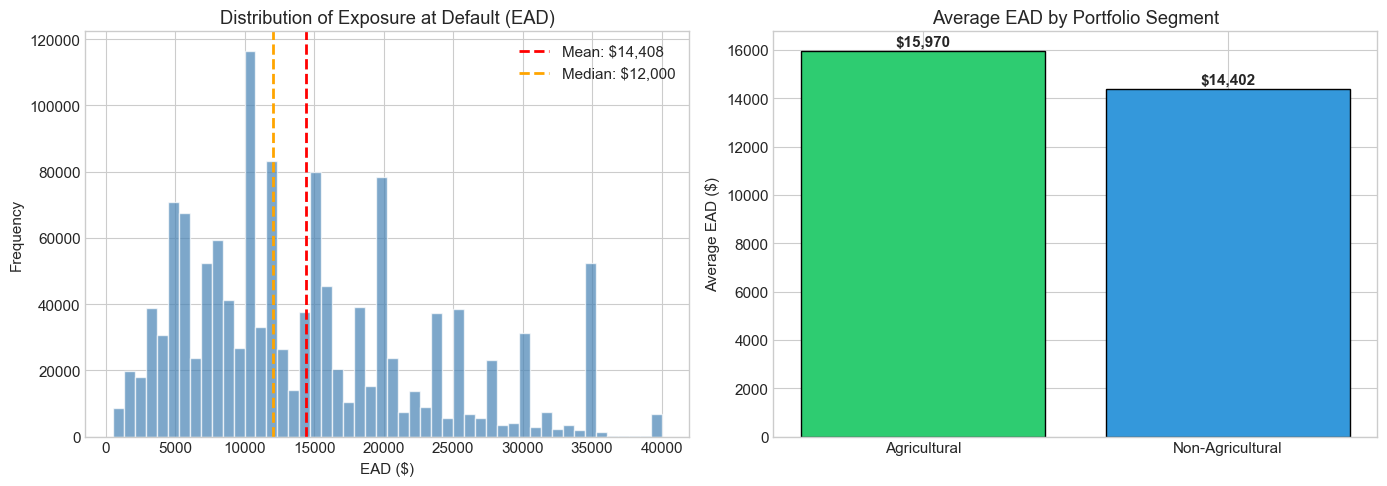

Figure saved to: outputs/figures/15_ead_distribution.png


In [5]:
# EAD distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# EAD distribution
ax1 = axes[0]
df['ead_est'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(df['ead_est'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${df["ead_est"].mean():,.0f}')
ax1.axvline(df['ead_est'].median(), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: ${df["ead_est"].median():,.0f}')
ax1.set_xlabel('EAD ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Exposure at Default (EAD)')
ax1.legend()

# EAD by portfolio segment
ax2 = axes[1]
segments = ['Agricultural', 'Non-Agricultural']
ead_means = [
    df[df['is_agri_portfolio']==1]['ead_est'].mean(),
    df[df['is_agri_portfolio']==0]['ead_est'].mean()
]
bars = ax2.bar(segments, ead_means, color=['#2ecc71', '#3498db'], edgecolor='black')
ax2.set_ylabel('Average EAD ($)')
ax2.set_title('Average EAD by Portfolio Segment')
for bar, val in zip(bars, ead_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'${val:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/15_ead_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/15_ead_distribution.png")

In [6]:
# EAD breakdown by portfolio
print("\nEAD Breakdown by Portfolio Segment:")
print("="*70)

ead_summary = df.groupby('is_agri_portfolio').agg(
    loan_count=('id', 'count'),
    total_ead=('ead_est', 'sum'),
    avg_ead=('ead_est', 'mean'),
    median_ead=('ead_est', 'median')
)

ead_summary.index = ['Non-Agricultural', 'Agricultural']
ead_summary['ead_pct'] = ead_summary['total_ead'] / ead_summary['total_ead'].sum() * 100

print(ead_summary)


EAD Breakdown by Portfolio Segment:
                  loan_count    total_ead    avg_ead  median_ead  ead_pct
Non-Agricultural     1341983  19326713150 14401.6080  12000.0000  99.5315
Agricultural            5697     90980325 15969.8657  14300.0000   0.4685


---
## 4. Loss Given Default (LGD) Estimation

### Methodology

We apply a **fixed LGD of 45%** based on:

1. **Regulatory Guidance:** Basel II Foundation IRB approach specifies 45% LGD for senior unsecured claims
2. **Industry Practice:** Consumer unsecured loans typically assume 40-60% LGD
3. **Conservative Estimation:** 45% represents a moderate assumption suitable for CECL provisioning

$$LGD = 0.45\ (45\%)$$

### LGD Interpretation

- LGD = 45% means that when a loan defaults, the lender expects to lose 45% of the exposure
- The remaining 55% represents expected recovery through collections, settlements, or collateral liquidation
- For unsecured consumer loans, recovery rates are typically lower than secured loans

In [7]:
# Define LGD assumption
LGD_ASSUMPTION = 0.45  # 45% LGD

print("Loss Given Default (LGD) Estimation")
print("="*60)
print(f"\nLGD Assumption: {LGD_ASSUMPTION*100:.0f}%")
print("\nRationale:")
print("  - Basel II Foundation IRB standard for unsecured exposures")
print("  - Industry standard for consumer unsecured lending")
print("  - Conservative estimate suitable for CECL provisioning")

Loss Given Default (LGD) Estimation

LGD Assumption: 45%

Rationale:
  - Basel II Foundation IRB standard for unsecured exposures
  - Industry standard for consumer unsecured lending
  - Conservative estimate suitable for CECL provisioning


In [8]:
# Apply LGD assumption to all loans
df['lgd_est'] = LGD_ASSUMPTION

print("\nLGD Applied to Portfolio:")
print(f"  All loans: LGD = {LGD_ASSUMPTION*100:.0f}%")
print(f"  Total loans: {len(df):,}")


LGD Applied to Portfolio:
  All loans: LGD = 45%
  Total loans: 1,347,680


In [9]:
# Alternative: Risk-adjusted LGD (for documentation purposes)
print("\nAlternative LGD Approaches (For Reference):")
print("="*60)

# Risk-based LGD tiers (not applied, for documentation only)
lgd_tiers = {
    'Low Risk (FICO >= 740)': 0.35,
    'Medium Risk (660 <= FICO < 740)': 0.45,
    'High Risk (FICO < 660)': 0.55
}

print("\nRisk-Based LGD Tiers (Alternative Approach):")
for tier, lgd in lgd_tiers.items():
    print(f"  {tier}: {lgd*100:.0f}%")

print("\n** Note: We use the fixed 45% LGD for simplicity and consistency **")


Alternative LGD Approaches (For Reference):

Risk-Based LGD Tiers (Alternative Approach):
  Low Risk (FICO >= 740): 35%
  Medium Risk (660 <= FICO < 740): 45%
  High Risk (FICO < 660): 55%

** Note: We use the fixed 45% LGD for simplicity and consistency **


---
## 5. Component Summary and Validation

In [10]:
# Summary of risk components
print("RISK COMPONENT SUMMARY")
print("="*70)

print("\n1. PROBABILITY OF DEFAULT (PD)")
print("-"*70)
print(f"   Method: Machine Learning Model (from Notebook 03)")
print(f"   Mean PD: {df['pd_hat'].mean():.4f} ({df['pd_hat'].mean()*100:.2f}%)")
print(f"   Median PD: {df['pd_hat'].median():.4f} ({df['pd_hat'].median()*100:.2f}%)")
print(f"   Range: {df['pd_hat'].min():.4f} - {df['pd_hat'].max():.4f}")

print("\n2. EXPOSURE AT DEFAULT (EAD)")
print("-"*70)
print(f"   Method: Loan Amount (Conservative)")
print(f"   Total EAD: ${df['ead_est'].sum():,.0f}")
print(f"   Mean EAD: ${df['ead_est'].mean():,.0f}")
print(f"   Median EAD: ${df['ead_est'].median():,.0f}")

print("\n3. LOSS GIVEN DEFAULT (LGD)")
print("-"*70)
print(f"   Method: Fixed Assumption (Basel II Standard)")
print(f"   LGD: {LGD_ASSUMPTION*100:.0f}%")
print(f"   Implied Recovery Rate: {(1-LGD_ASSUMPTION)*100:.0f}%")

RISK COMPONENT SUMMARY

1. PROBABILITY OF DEFAULT (PD)
----------------------------------------------------------------------
   Method: Machine Learning Model (from Notebook 03)
   Mean PD: 0.4657 (46.57%)
   Median PD: 0.4712 (47.12%)
   Range: 0.0060 - 0.9203

2. EXPOSURE AT DEFAULT (EAD)
----------------------------------------------------------------------
   Method: Loan Amount (Conservative)
   Total EAD: $19,417,693,475
   Mean EAD: $14,408
   Median EAD: $12,000

3. LOSS GIVEN DEFAULT (LGD)
----------------------------------------------------------------------
   Method: Fixed Assumption (Basel II Standard)
   LGD: 45%
   Implied Recovery Rate: 55%


In [11]:
# Comparison by portfolio segment
print("\nRISK COMPONENTS BY PORTFOLIO SEGMENT")
print("="*70)

segment_summary = df.groupby('is_agri_portfolio').agg(
    loan_count=('id', 'count'),
    mean_pd=('pd_hat', 'mean'),
    median_pd=('pd_hat', 'median'),
    total_ead=('ead_est', 'sum'),
    mean_ead=('ead_est', 'mean'),
    lgd=('lgd_est', 'mean')
)

segment_summary.index = ['Non-Agricultural', 'Agricultural']

print(f"\n{'Segment':<20} {'Count':>12} {'Mean PD':>12} {'Mean EAD':>15} {'LGD':>10}")
print("-"*70)
for idx, row in segment_summary.iterrows():
    print(f"{idx:<20} {row['loan_count']:>12,} {row['mean_pd']:>11.4f} ${row['mean_ead']:>13,.0f} {row['lgd']:>9.0%}")


RISK COMPONENTS BY PORTFOLIO SEGMENT

Segment                     Count      Mean PD        Mean EAD        LGD
----------------------------------------------------------------------
Non-Agricultural      1,341,983.0      0.4651 $       14,402       45%
Agricultural              5,697.0      0.5933 $       15,970       45%


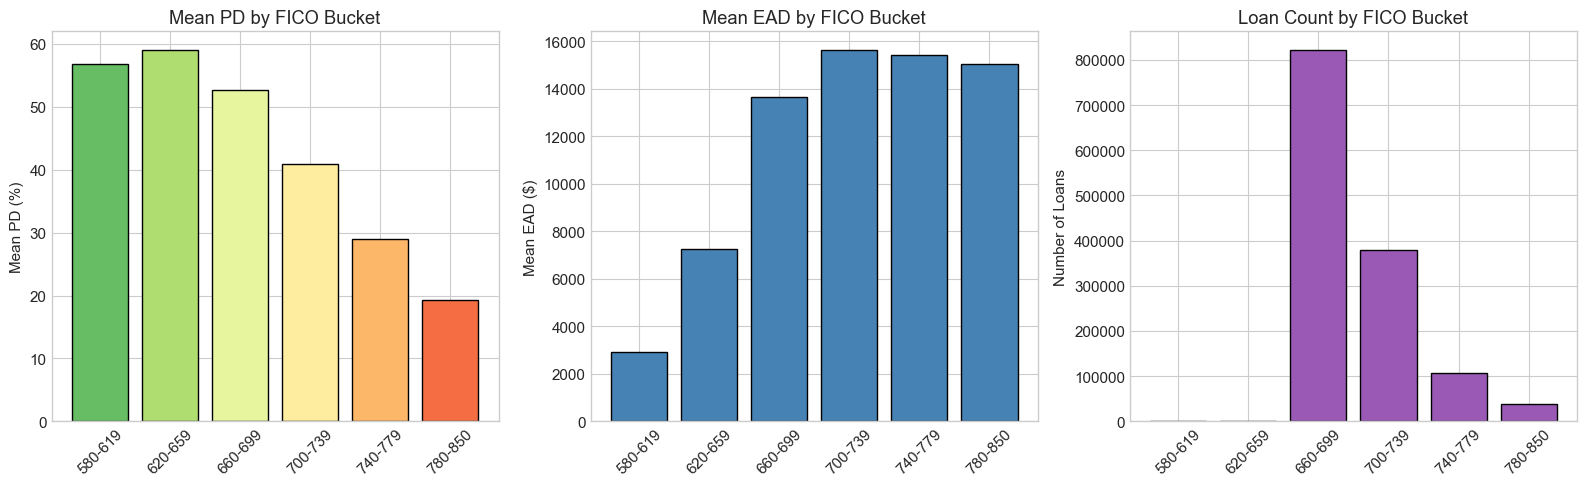

Figure saved to: outputs/figures/16_risk_components_by_fico.png


In [12]:
# Visualize risk components by FICO bucket
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Group by FICO bucket
fico_analysis = df.groupby('fico_bucket', observed=True).agg(
    mean_pd=('pd_hat', 'mean'),
    mean_ead=('ead_est', 'mean'),
    loan_count=('id', 'count')
)

# Mean PD by FICO bucket
ax1 = axes[0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(fico_analysis)))
bars1 = ax1.bar(range(len(fico_analysis)), fico_analysis['mean_pd']*100, color=colors, edgecolor='black')
ax1.set_xticks(range(len(fico_analysis)))
ax1.set_xticklabels(fico_analysis.index, rotation=45)
ax1.set_ylabel('Mean PD (%)')
ax1.set_title('Mean PD by FICO Bucket')

# Mean EAD by FICO bucket
ax2 = axes[1]
bars2 = ax2.bar(range(len(fico_analysis)), fico_analysis['mean_ead'], color='steelblue', edgecolor='black')
ax2.set_xticks(range(len(fico_analysis)))
ax2.set_xticklabels(fico_analysis.index, rotation=45)
ax2.set_ylabel('Mean EAD ($)')
ax2.set_title('Mean EAD by FICO Bucket')

# Loan count by FICO bucket
ax3 = axes[2]
bars3 = ax3.bar(range(len(fico_analysis)), fico_analysis['loan_count'], color='#9b59b6', edgecolor='black')
ax3.set_xticks(range(len(fico_analysis)))
ax3.set_xticklabels(fico_analysis.index, rotation=45)
ax3.set_ylabel('Number of Loans')
ax3.set_title('Loan Count by FICO Bucket')

plt.tight_layout()
plt.savefig('../outputs/figures/16_risk_components_by_fico.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/16_risk_components_by_fico.png")

---
## 6. Expected Loss Preview

Before full ECL computation in Notebook 05, let's preview the expected loss at loan level:

$$Expected\ Loss_i = PD_i \times LGD_i \times EAD_i$$

In [13]:
# Preview expected loss calculation
print("Expected Loss Preview")
print("="*60)

# Calculate loan-level expected loss
df['el_preview'] = df['pd_hat'] * df['lgd_est'] * df['ead_est']

# Summary statistics
print(f"\nLoan-Level Expected Loss Statistics:")
print(f"  Mean EL per loan: ${df['el_preview'].mean():,.2f}")
print(f"  Median EL per loan: ${df['el_preview'].median():,.2f}")
print(f"  Total Expected Loss (Portfolio): ${df['el_preview'].sum():,.0f}")
print(f"  Total EAD (Portfolio): ${df['ead_est'].sum():,.0f}")
print(f"  Portfolio EL Rate: {df['el_preview'].sum()/df['ead_est'].sum()*100:.4f}%")

Expected Loss Preview

Loan-Level Expected Loss Statistics:
  Mean EL per loan: $3,179.13
  Median EL per loan: $2,526.87
  Total Expected Loss (Portfolio): $4,284,450,663
  Total EAD (Portfolio): $19,417,693,475
  Portfolio EL Rate: 22.0647%


In [14]:
# EL preview by portfolio segment
print("\nExpected Loss Preview by Portfolio Segment:")
print("="*70)

el_segment = df.groupby('is_agri_portfolio').agg(
    total_el=('el_preview', 'sum'),
    mean_el=('el_preview', 'mean'),
    total_ead=('ead_est', 'sum')
)

el_segment['el_rate'] = el_segment['total_el'] / el_segment['total_ead'] * 100
el_segment.index = ['Non-Agricultural', 'Agricultural']

print(f"\n{'Segment':<20} {'Total EL':>18} {'Mean EL':>15} {'EL Rate':>12}")
print("-"*70)
for idx, row in el_segment.iterrows():
    print(f"{idx:<20} ${row['total_el']:>16,.0f} ${row['mean_el']:>13,.2f} {row['el_rate']:>11.4f}%")


Expected Loss Preview by Portfolio Segment:

Segment                        Total EL         Mean EL      EL Rate
----------------------------------------------------------------------
Non-Agricultural     $   4,258,868,631 $     3,173.56     22.0362%
Agricultural         $      25,582,032 $     4,490.44     28.1182%


In [15]:
# Remove preview column (will be calculated properly in Notebook 05)
df = df.drop('el_preview', axis=1)

---
## 7. Save Data with Risk Components

In [16]:
# Final dataset review
print("Final Dataset with Risk Components:")
print("="*60)
print(f"\nColumns:")
for col in df.columns:
    print(f"  - {col}")

print(f"\nShape: {df.shape}")

Final Dataset with Risk Components:

Columns:
  - id
  - issue_date
  - issue_year
  - issue_month
  - loan_amnt
  - revenue
  - dti_n
  - fico_n
  - emp_length
  - purpose
  - home_ownership_n
  - addr_state
  - is_agri_portfolio
  - is_agri_state
  - is_small_business
  - fico_bucket
  - income_bucket
  - pd_band
  - Default
  - pd_hat
  - ead_est
  - lgd_est

Shape: (1347680, 22)


In [17]:
# Save dataset with LGD and EAD
OUTPUT_PATH = '../data_processed/loans_with_lgd_ead.csv'
df.to_csv(OUTPUT_PATH, index=False)

print(f"Data saved to: {OUTPUT_PATH}")
print(f"Shape: {df.shape}")

Data saved to: ../data_processed/loans_with_lgd_ead.csv
Shape: (1347680, 22)


In [18]:
# Save LGD/EAD assumptions as metadata
import json

lgd_ead_metadata = {
    'lgd_assumption': LGD_ASSUMPTION,
    'lgd_method': 'Fixed 45% (Basel II Foundation IRB Standard)',
    'ead_method': 'Loan Amount (Conservative)',
    'total_portfolio_ead': float(df['ead_est'].sum()),
    'mean_ead': float(df['ead_est'].mean()),
    'median_ead': float(df['ead_est'].median()),
    'total_loans': len(df)
}

with open('../outputs/models/lgd_ead_metadata.json', 'w') as f:
    json.dump(lgd_ead_metadata, f, indent=2)

print("LGD/EAD metadata saved to: outputs/models/lgd_ead_metadata.json")

LGD/EAD metadata saved to: outputs/models/lgd_ead_metadata.json


---
## 8. LGD and EAD Summary

### Key Results

1. **EAD Estimation:**
   - Used loan amount as EAD (conservative approach)
   - Total portfolio exposure: As calculated above
   - Agricultural segment has higher average EAD (larger loan sizes)

2. **LGD Assumption:**
   - Fixed 45% LGD applied to all loans
   - Based on Basel II Foundation IRB standard for unsecured exposures
   - Implies 55% recovery rate

3. **Portfolio Insights:**
   - Agricultural segment shows higher PD and EAD
   - Combined with fixed LGD, this results in higher expected loss for agricultural segment
   - Risk concentration analysis reveals FICO as key driver

### Assumptions and Limitations

1. **EAD Assumption:** Using loan amount assumes full utilization; actual EAD may be lower for partially repaid loans
2. **LGD Assumption:** Fixed LGD does not account for loan-specific factors that may affect recovery
3. **No Recovery Modeling:** Detailed recovery analysis would require workout/collection data

### Next Steps

1. Compute full ECL (Notebook 05)
2. Perform stress testing (Notebook 06)

In [19]:
print("="*60)
print("NOTEBOOK 04 COMPLETE")
print("="*60)
print(f"\nLGD and EAD estimation completed successfully.")
print(f"LGD Assumption: {LGD_ASSUMPTION*100:.0f}%")
print(f"EAD Method: Loan Amount")
print(f"Data saved to: data_processed/loans_with_lgd_ead.csv")

NOTEBOOK 04 COMPLETE

LGD and EAD estimation completed successfully.
LGD Assumption: 45%
EAD Method: Loan Amount
Data saved to: data_processed/loans_with_lgd_ead.csv
